In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import transformers
import scipy as sp
import pandas as pd
import numpy as np
import shap
import sklearn
import os
import spacy
import itertools

In [13]:
def remove_stop_words(text, lang):

    nlp = spacy.load(f"{lang}_core_news_sm")

    clean_texts = []
    for t in text:
        doc = nlp(t)
    
        # Remove stopwords
        filtered_words = [token.text for token in doc if not token.is_stop]
    
        # Join the filtered words to form a clean text
        clean_text = ' '.join(filtered_words)
        clean_texts.append(clean_text)

    return clean_texts

def create_Xy(df, lang, p1, p2, stop=False):

    # return the first column as a list where "persona" is "human"
    texts_p1 = df[df['persona'] == p1]['text'].tolist()
    # texts_p1 = [text.replace("[REF]", "") for text in texts_p1]
    texts_p2 = df[df['persona'] == p2]['text'].tolist()

    # combine the two lists
    texts = texts_p1 + texts_p2
    # labels for the two classes as a list
    # y = df[df['persona'].isin(['human', persona])]['persona'].tolist()
    y = [0] * len(texts_p1) + [1] * len(texts_p2)

    if stop:
        return remove_stop_words(texts, lang), y
    else:
        return texts, y

In [40]:
def train_model(texts, y):
    corpus_train, corpus_test, y_train, y_test = train_test_split(
        texts, y, test_size=0.2, random_state=7
    )

    vectorizer = TfidfVectorizer(min_df=10)
    X_train = vectorizer.fit_transform(
        corpus_train
    ).toarray()  
    X_test = vectorizer.transform(corpus_test).toarray()

    model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
    model.fit(X_train, y_train)

    # print(classification_report(y_test, model.predict(X_test)))

    return model, classification_report(y_test, model.predict(X_test), output_dict=True)

In [41]:
# Create an empty DataFrame
dfs = []

corpora = ['20min', 'cnn', 'pubmed_en', 'pubmed_de', 'zora_en', 'zora_de', 'cs_en', 'cs_de', 'e3c', 'ggponc']

english_corpora = ['cnn', 'pubmed_en', 'zora_en', 'cs_en', 'e3c']
personas = ['human', 'continue', 'explain', 'create']

lang = ""

In [ ]:
for corpus in corpora:
    if corpus in english_corpora:
        lang = "en"
    else:
        lang = "de"

    inputdf = pd.read_csv(f"../shapdata/{corpus}.csv")

    for p1, p2 in itertools.combinations(personas, 2):
        texts, y = create_Xy(inputdf, lang, p1, p2, stop=False)
        # print(corpus, p1, p2)
        _, class_dict = train_model(texts, y)
        
        data = []

        for label in ["0", "1"]:
            # print(label, class_dict[label])
            precision = class_dict[label]['precision']
            # print(precision)
            recall = class_dict[label]['recall']
            f1_score = class_dict[label]['f1-score']
            support = class_dict[label]['support']  # Assuming support value is same for all labels
        
            data.append({'label': label, 'precision': precision, 'recall': recall, 'f1-score': f1_score, 'corpus': corpus, 'persona1': p1, 'persona2': p2})

        # Append the list to the list of DataFrames
        dfs.append(pd.DataFrame(data))

# Concatenate all DataFrames in the list
result_df = pd.concat(dfs, ignore_index=True)

In [39]:
result_df.to_csv('../results/loglin_results.csv', index=False)

In [43]:
explainer = shap.Explainer(
    model, X_train,feature_names=vectorizer.get_feature_names_out()
)
shap_values = explainer(X_test)

NameError: name 'model' is not defined

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


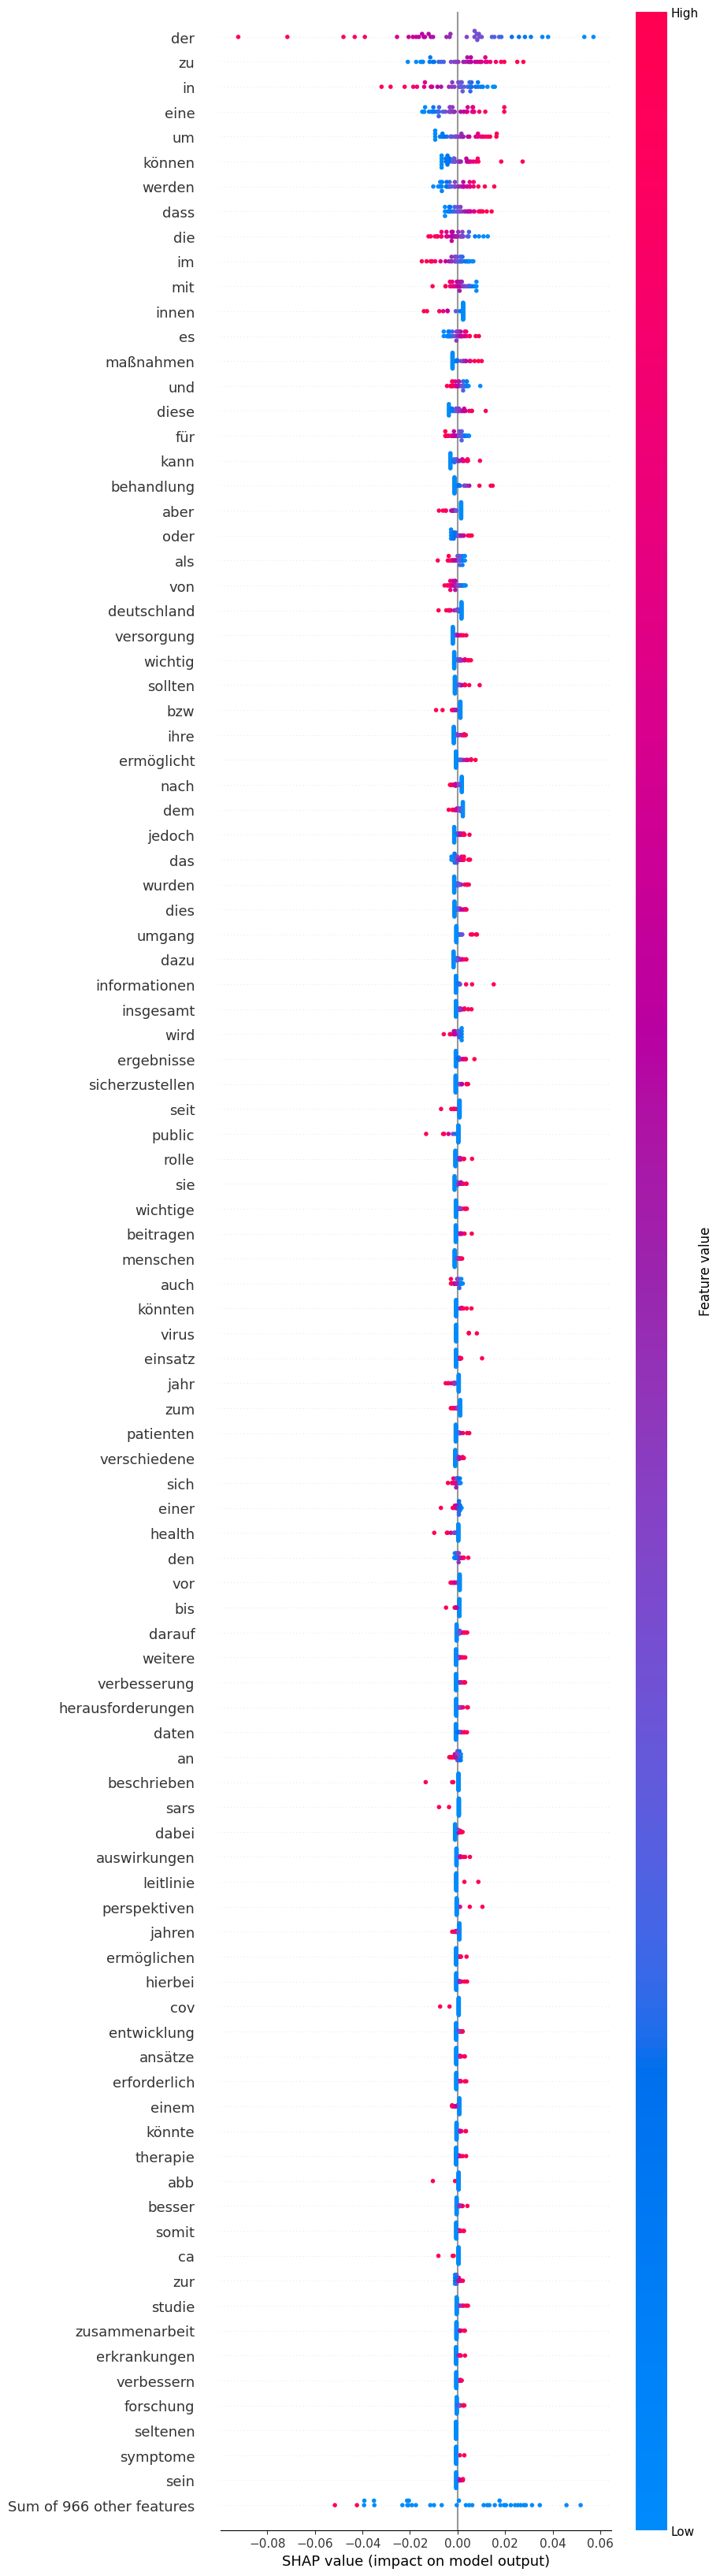

In [157]:
shap.plots.beeswarm(shap_values, max_display=100)

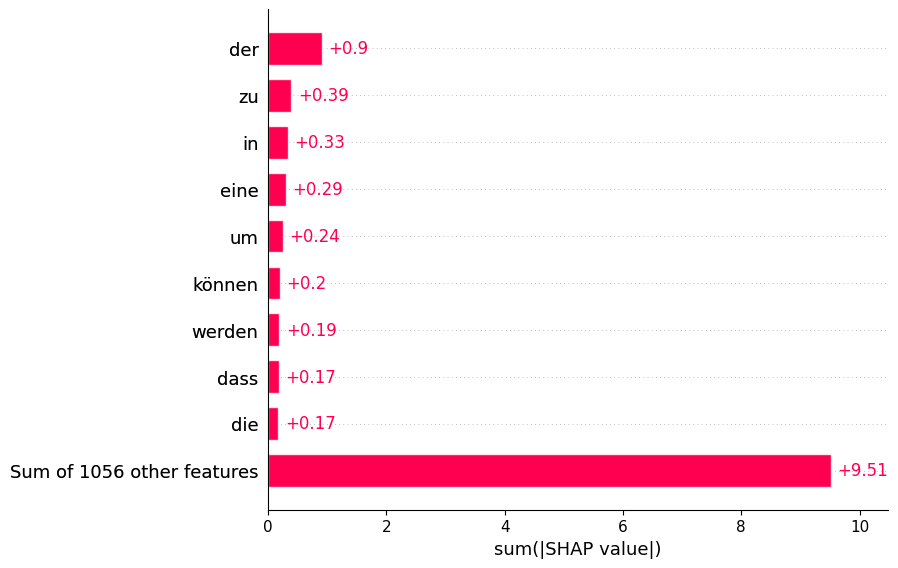

In [158]:
shap.plots.bar(shap_values.abs.sum(0))

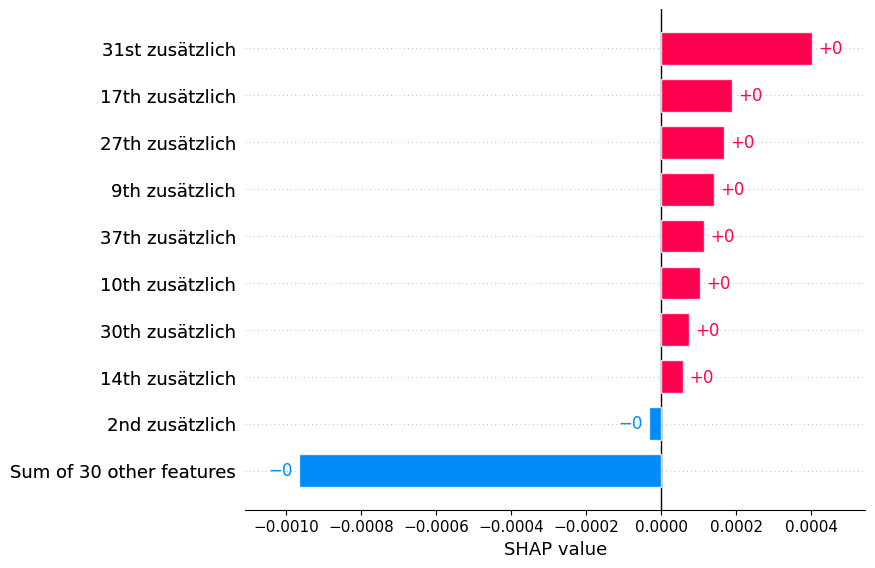

In [164]:
shap.plots.bar(shap_values[:, "zusätzlich"])

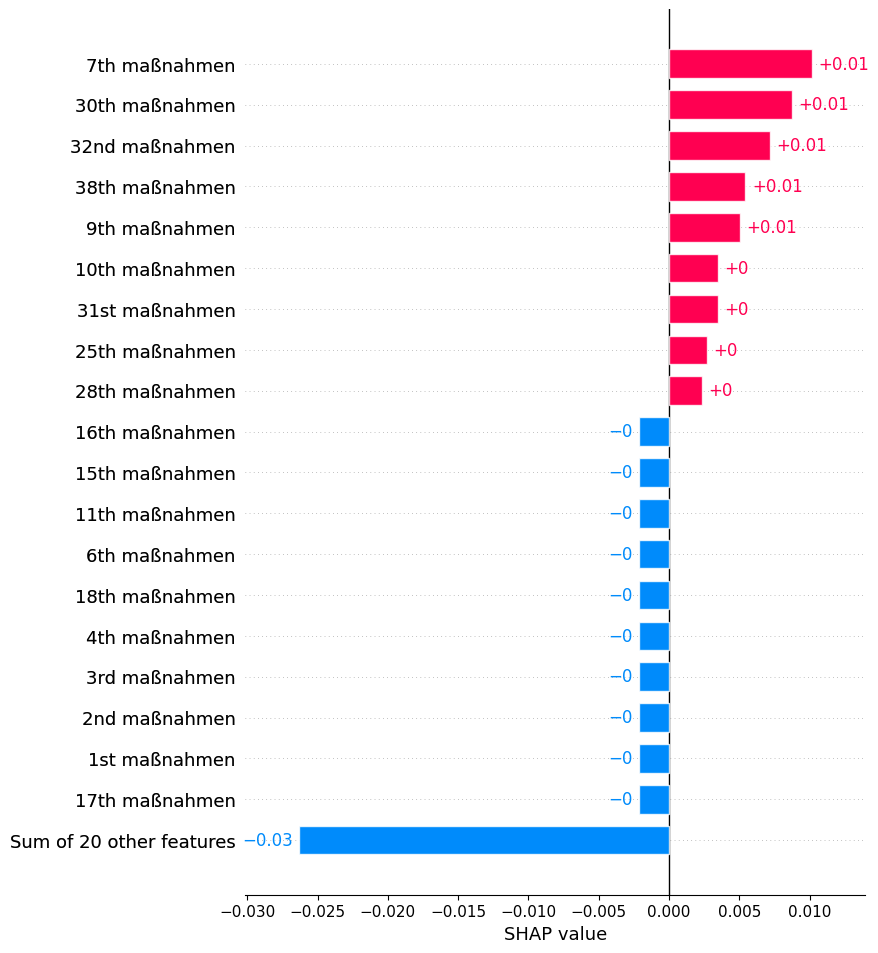

In [172]:
shap.plots.bar(shap_values[:, "maßnahmen"],max_display=20)